In [35]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [36]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [37]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

# idf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# idf_title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

In [38]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [39]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val
        

In [40]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.

'''
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
'''

#if you do NOT have RAM >= 12GB, use the code below.
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)


In [46]:
# Utility functions

def display_img(url,ax,fig):
    import PIL.Image
    # we get the url of the apparel and download it
    response = requests.get(url)
    img =PIL.Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
# Utility functions

def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

In [47]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [48]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [49]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

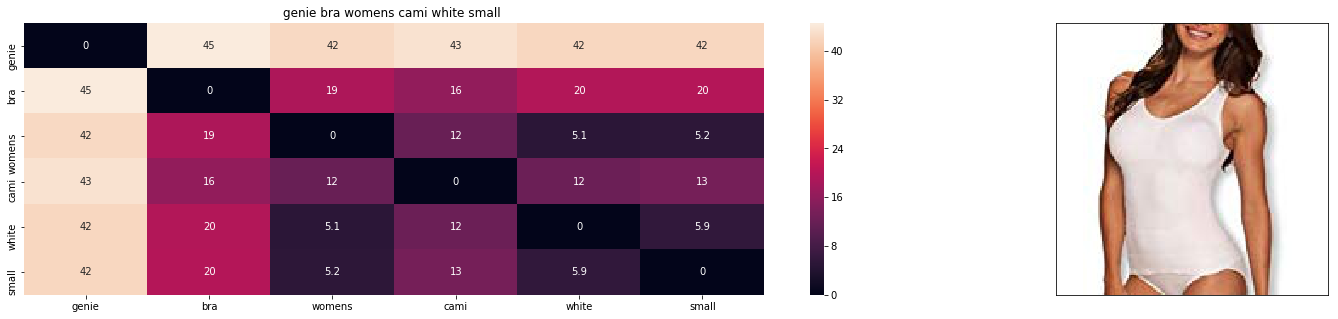

ASIN : B06XYTF99Z
Brand : Genie
euclidean distance from input : 0.0


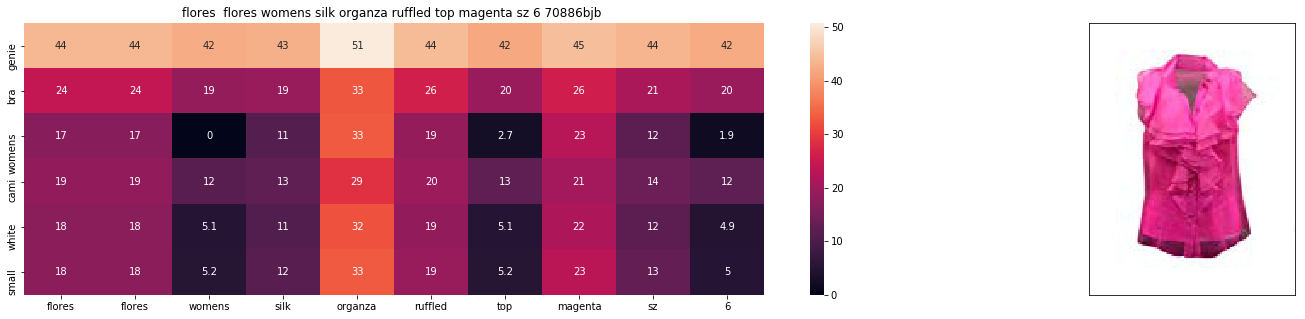

ASIN : B01BU802XA
Brand : Flores
euclidean distance from input : 15.929313151041667


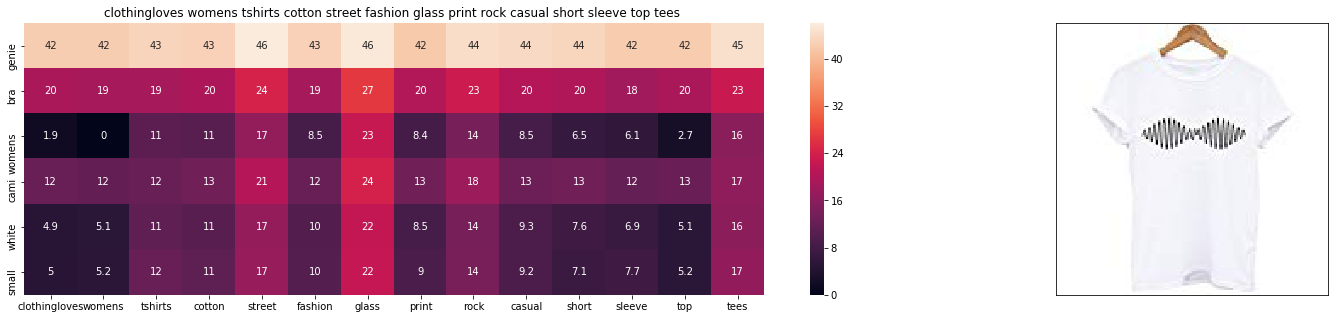

ASIN : B074KD6ZCP
Brand : ClothingLoves
euclidean distance from input : 17.274076334755875


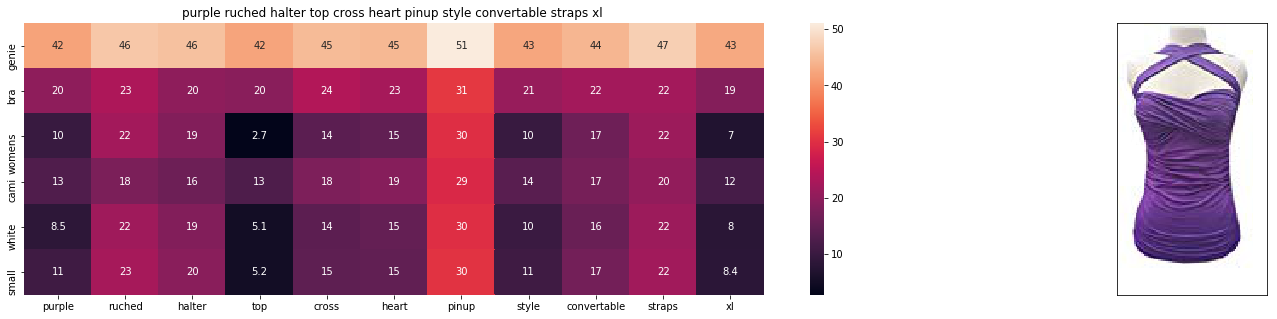

ASIN : B01I4A8T3M
Brand : Non Branded
euclidean distance from input : 17.56409429409498


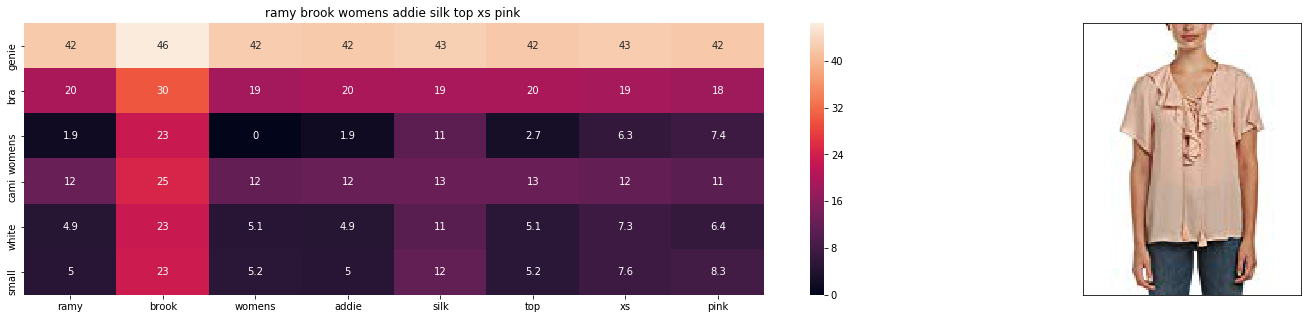

ASIN : B074P9YR8S
Brand : Ramy Brook
euclidean distance from input : 17.713355260078053


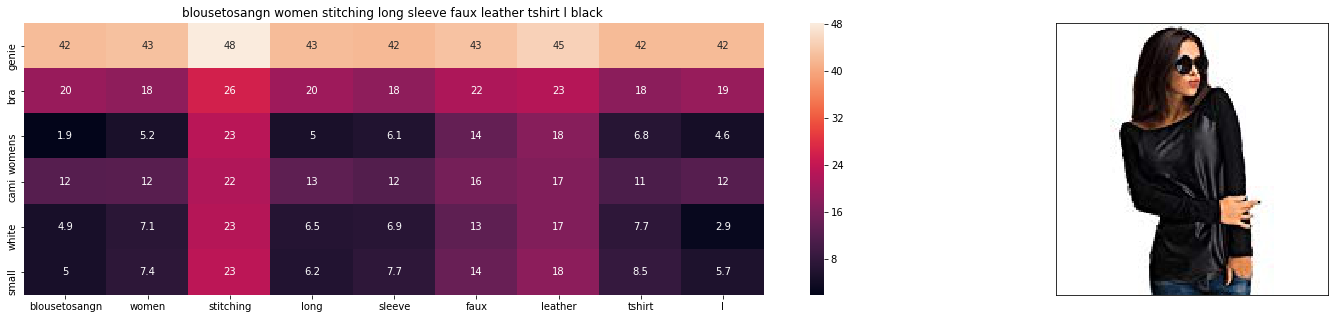

ASIN : B01MXG0FNQ
Brand : Tosangn
euclidean distance from input : 17.76730448404948


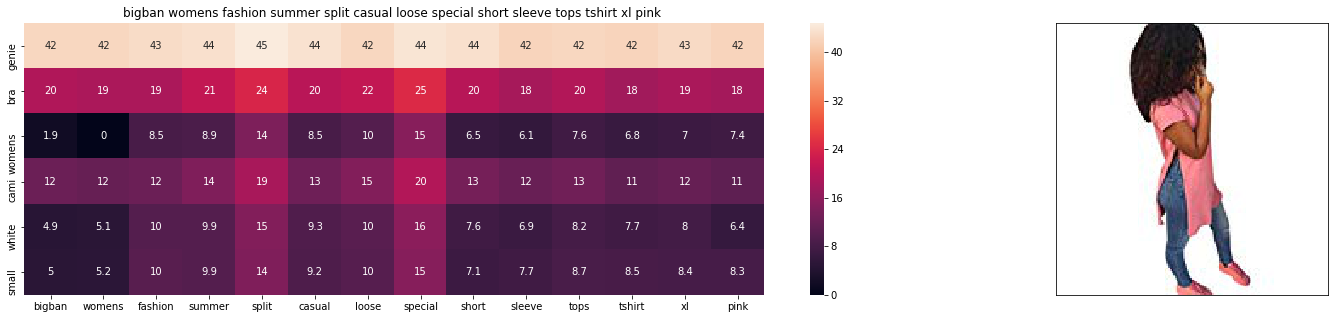

ASIN : B01HXCS9BO
Brand : Bigban
euclidean distance from input : 17.82589340209961


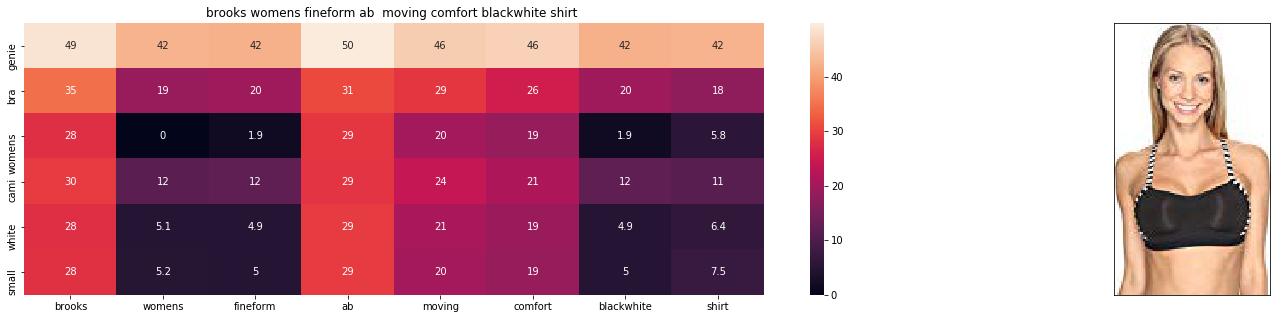

ASIN : B01GU92OPI
Brand : Brooks
euclidean distance from input : 17.933297127913583


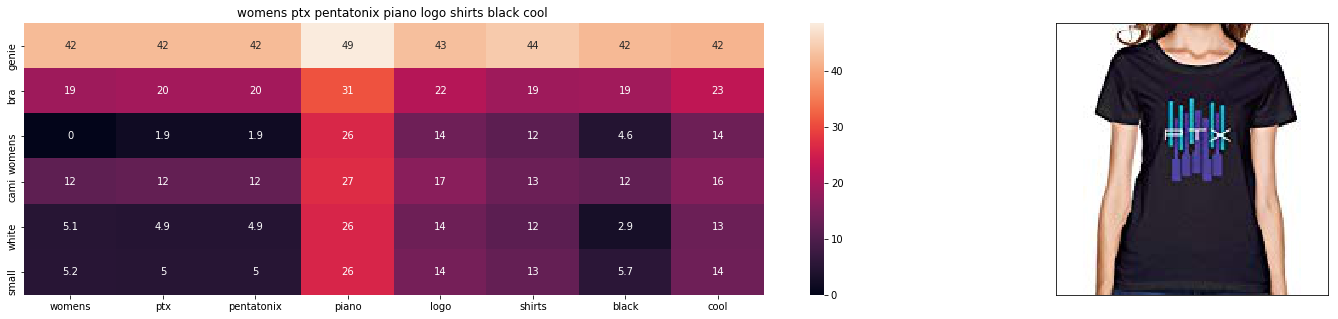

ASIN : B01JLSSCRY
Brand : LEEMASTER
euclidean distance from input : 18.06800898123697


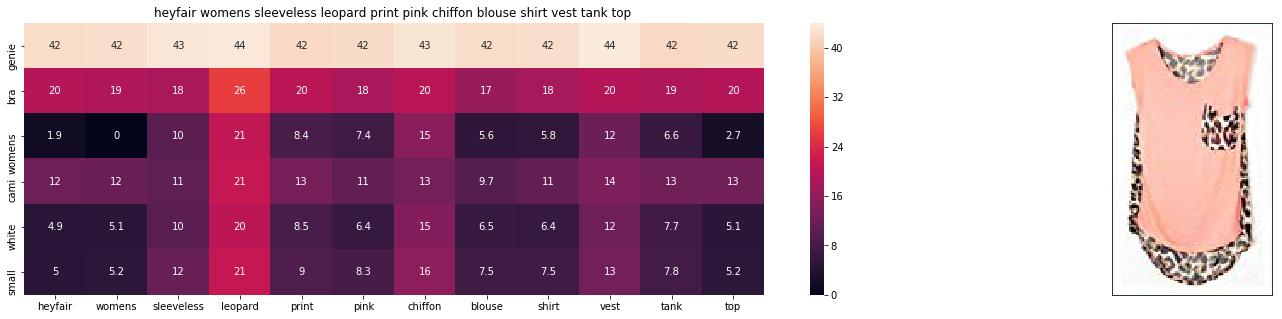

ASIN : B00W3MMKS8
Brand : HEYFAIR
euclidean distance from input : 18.11158676147461


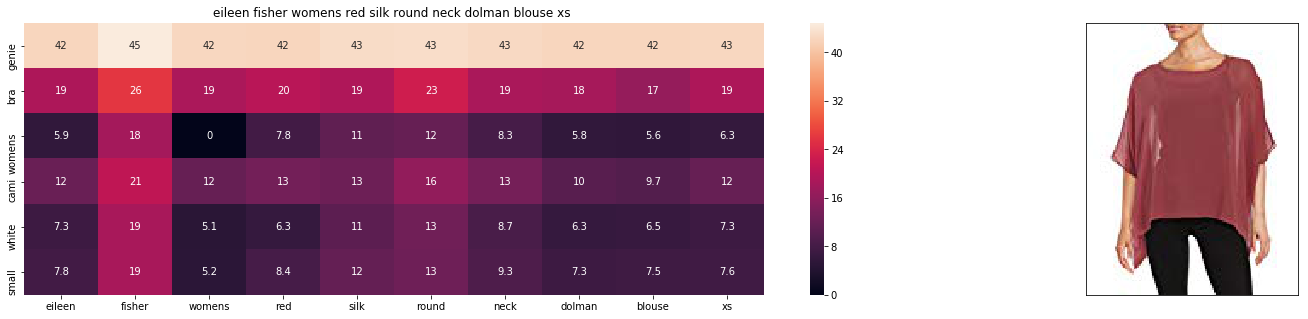

ASIN : B06Y3CKDML
Brand : Eileen Fisher
euclidean distance from input : 18.19184596238925


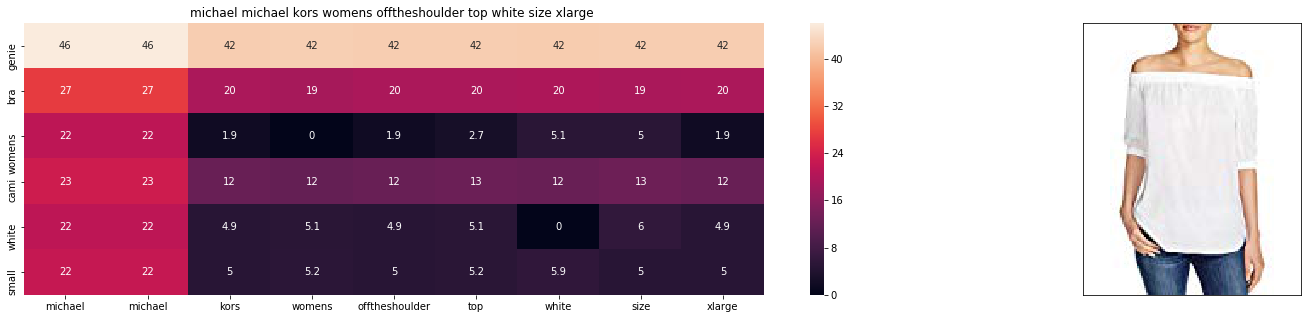

ASIN : B01BOU2FRU
Brand : MICHAEL Michael Kors
euclidean distance from input : 18.197763365595694


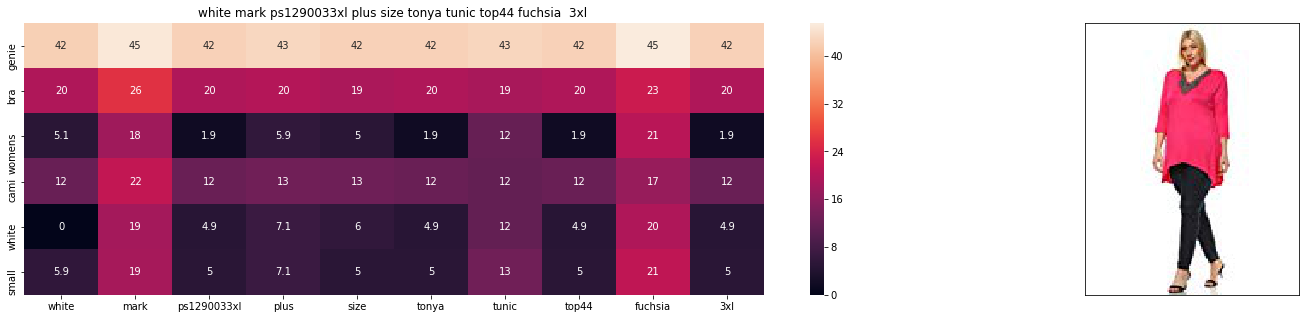

ASIN : B0747WZHK2
Brand : White Mark
euclidean distance from input : 18.20709457892571


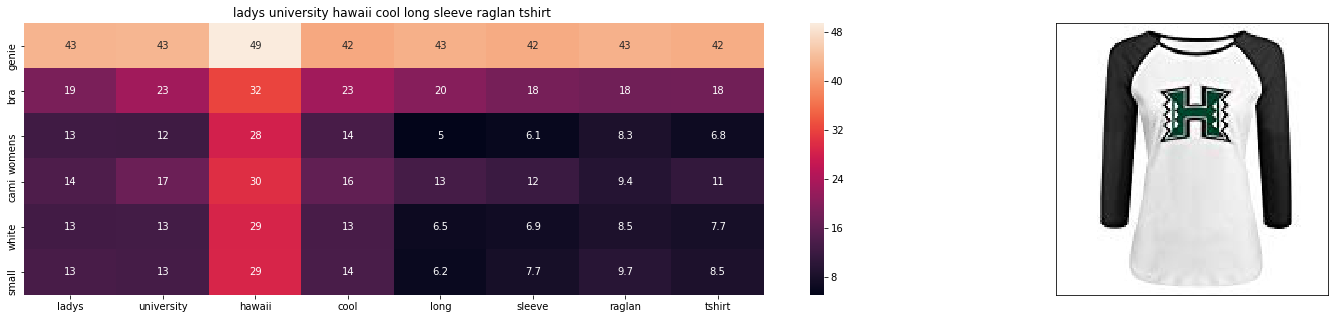

ASIN : B01M4FR83Y
Brand : ILITECK-P
euclidean distance from input : 18.21782989501953


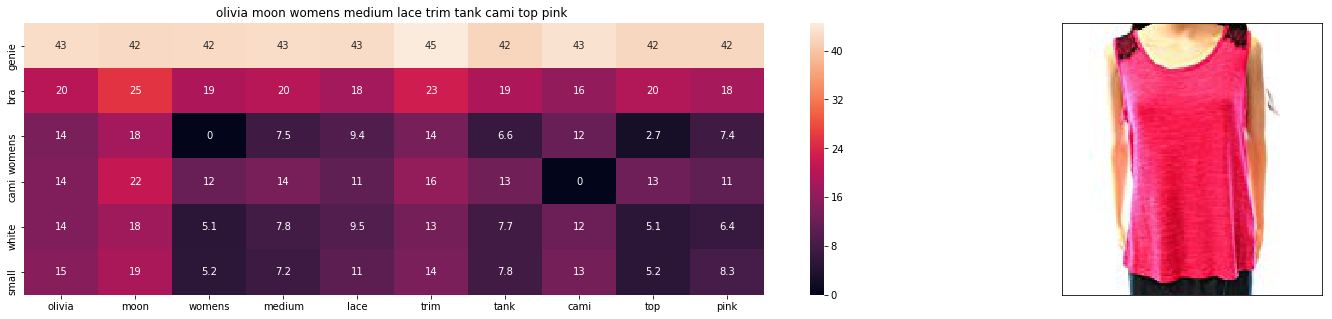

ASIN : B071W8XRB2
Brand : Olivia Moon
euclidean distance from input : 18.23851852912102


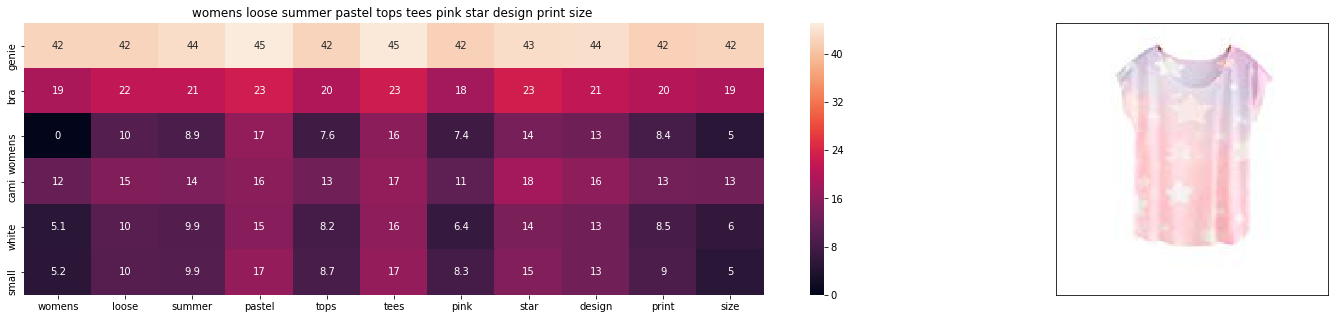

ASIN : B01L79BFYC
Brand : Namnoi Clothing Store
euclidean distance from input : 18.277255807408846


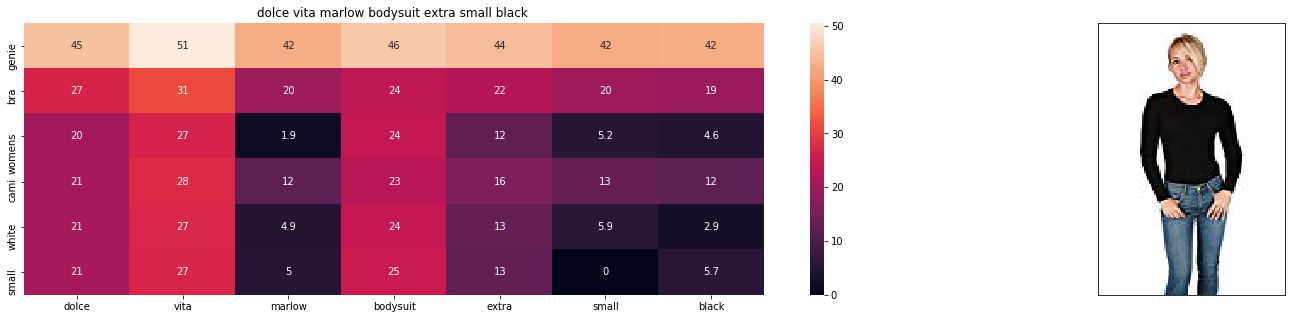

ASIN : B01N5K8RVX
Brand : Dolce Vita
euclidean distance from input : 18.293704482897063


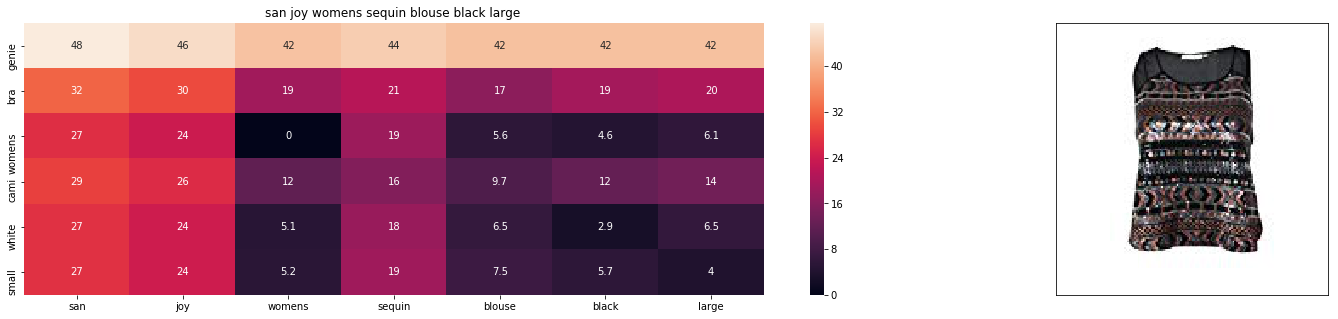

ASIN : B073WKFKLZ
Brand : Sanjoy
euclidean distance from input : 18.29460678100586


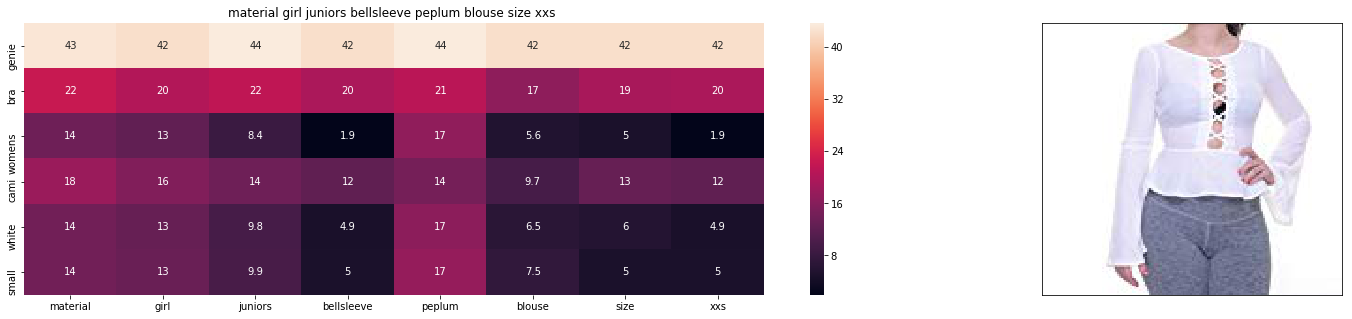

ASIN : B06XSH8WSS
Brand : Material Girl
euclidean distance from input : 18.321650491246736


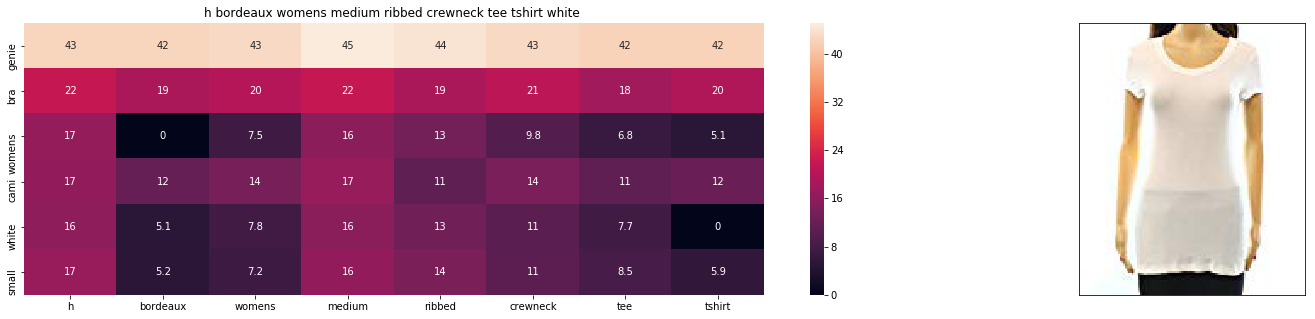

ASIN : B06XDNVWBJ
Brand : H By Bordeaux
euclidean distance from input : 18.331772011946786


In [53]:
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])


from IPython.display import display, Image, SVG, Math, YouTubeVideo


#get similar products using CNN features (VGG-16)
def get_similar_products(doc_id,w1,w2,w3, num_results):
    doc_id = asins.index(df_asins[doc_id])
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist1 = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist+ w3 *pairwise_dist1)/float(w1 + w2+w3)
    
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])
    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

get_similar_products(1256,5,5,5, 20)


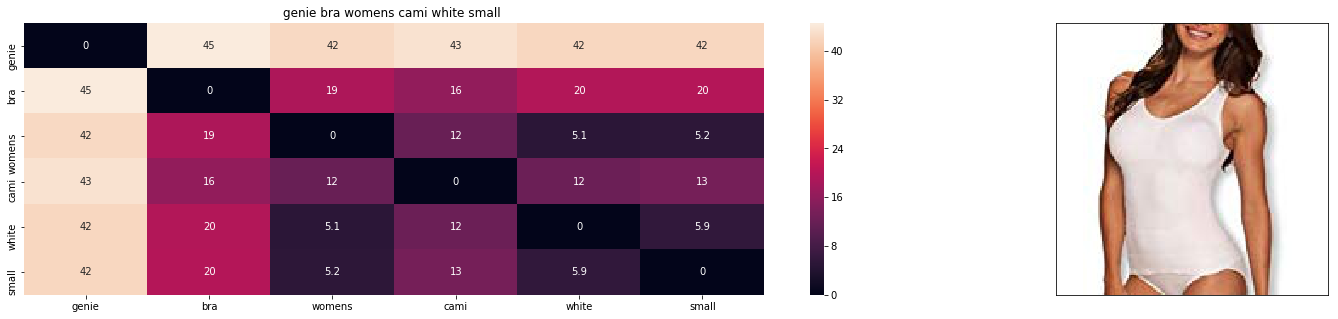

ASIN : B06XYTF99Z
Brand : Genie
euclidean distance from input : 0.0


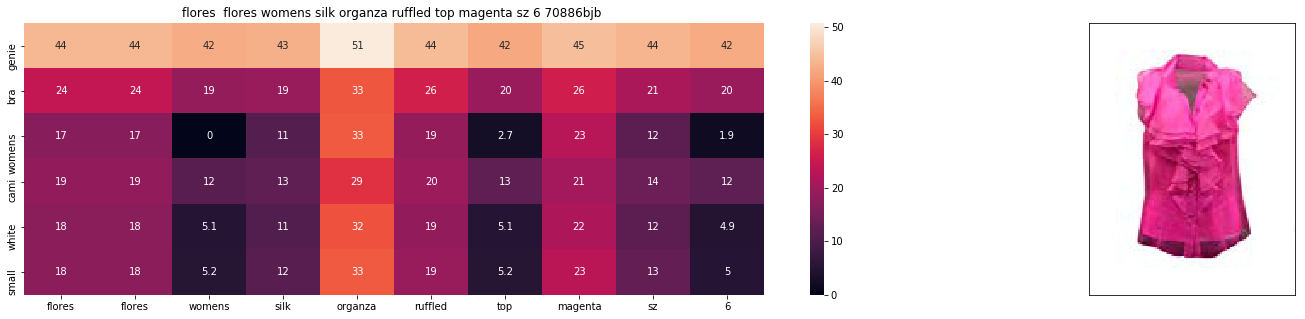

ASIN : B01BU802XA
Brand : Flores
euclidean distance from input : 23.08909715924944


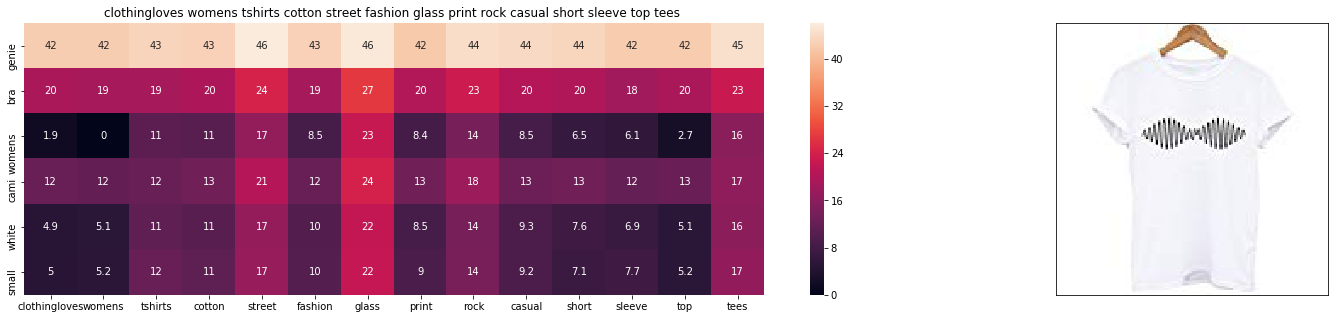

ASIN : B074KD6ZCP
Brand : ClothingLoves
euclidean distance from input : 25.61868760249059


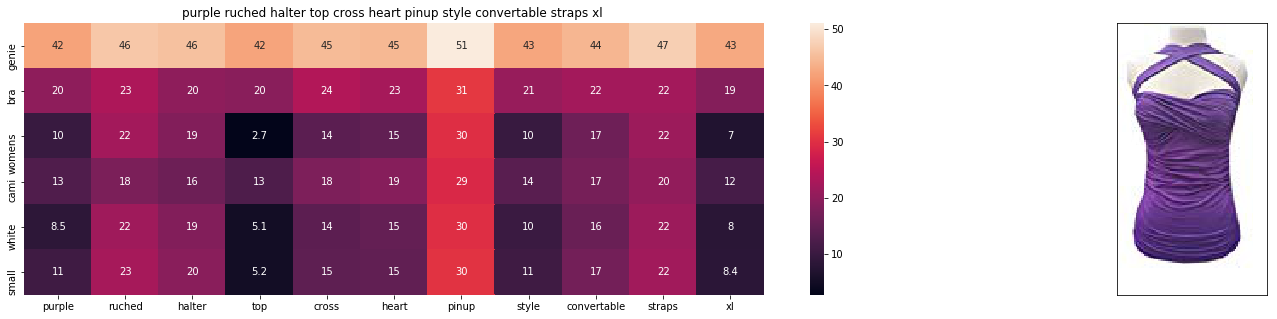

ASIN : B01I4A8T3M
Brand : Non Branded
euclidean distance from input : 25.66846894014646


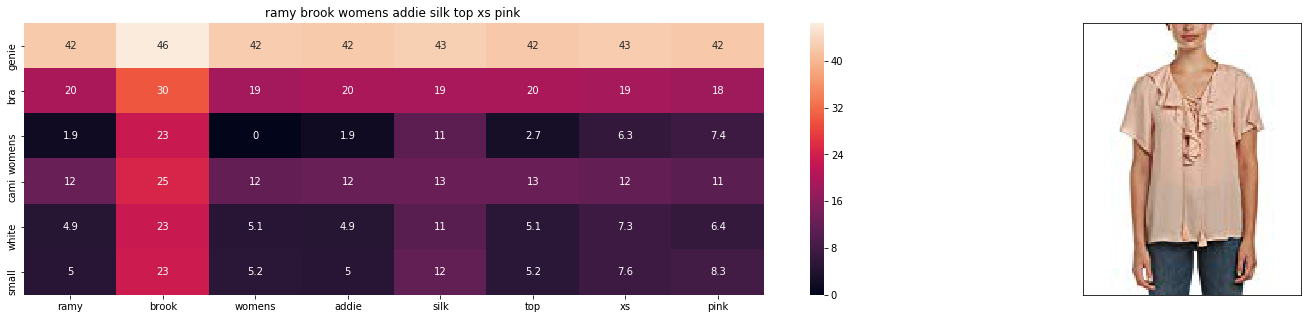

ASIN : B074P9YR8S
Brand : Ramy Brook
euclidean distance from input : 25.953335818111025


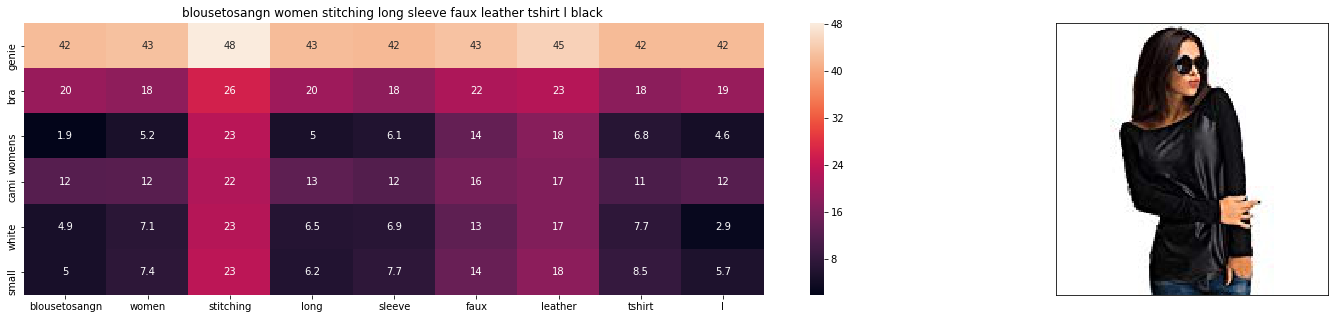

ASIN : B01MXG0FNQ
Brand : Tosangn
euclidean distance from input : 26.15723201206752


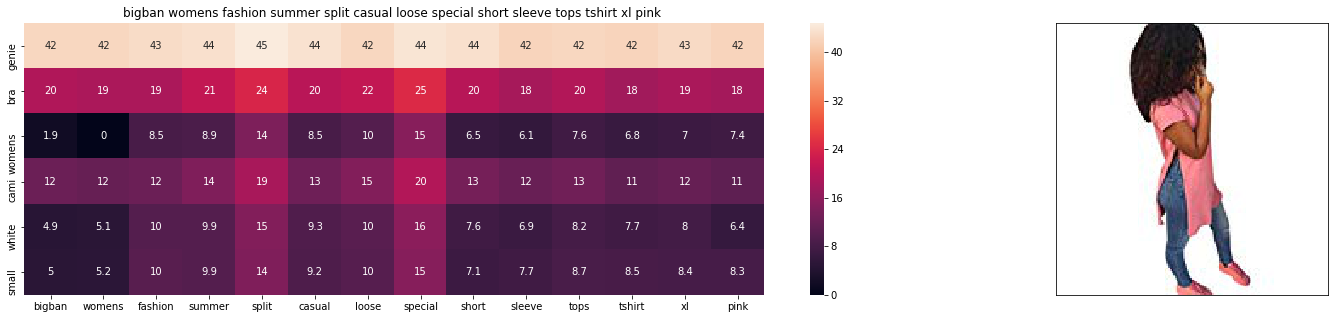

ASIN : B01HXCS9BO
Brand : Bigban
euclidean distance from input : 26.243404115949357


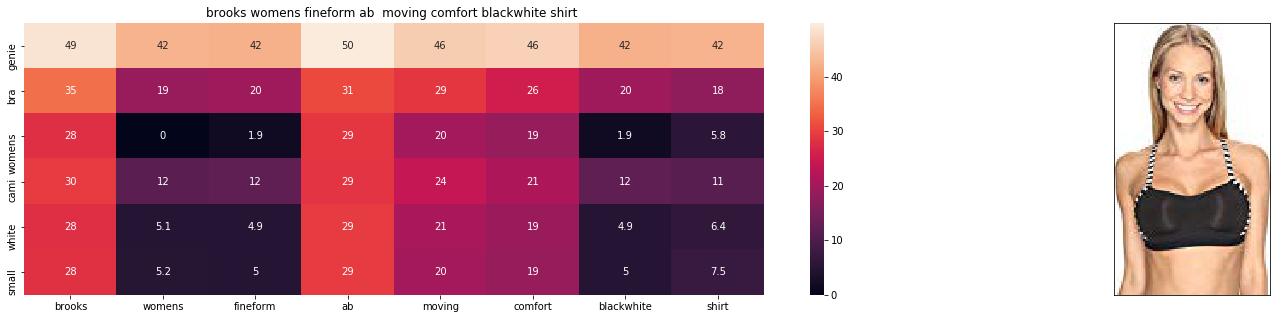

ASIN : B01GU92OPI
Brand : Brooks
euclidean distance from input : 26.30971911031151


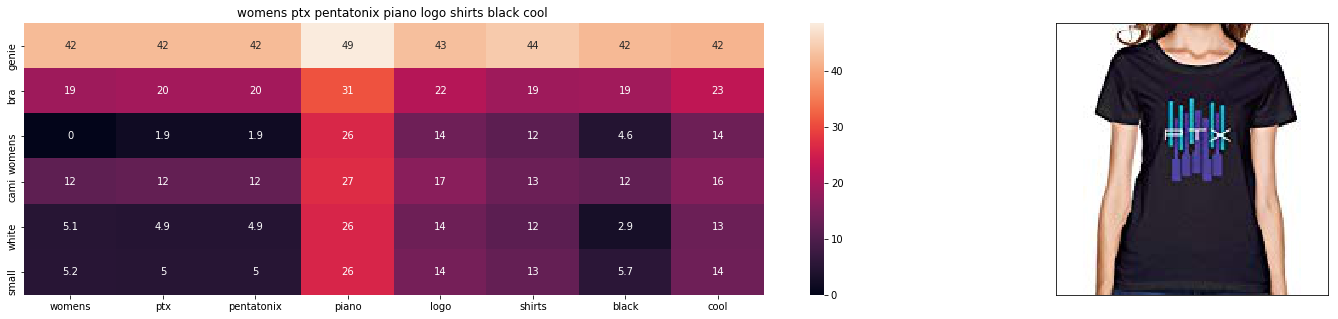

ASIN : B01JLSSCRY
Brand : LEEMASTER
euclidean distance from input : 26.404819368280204


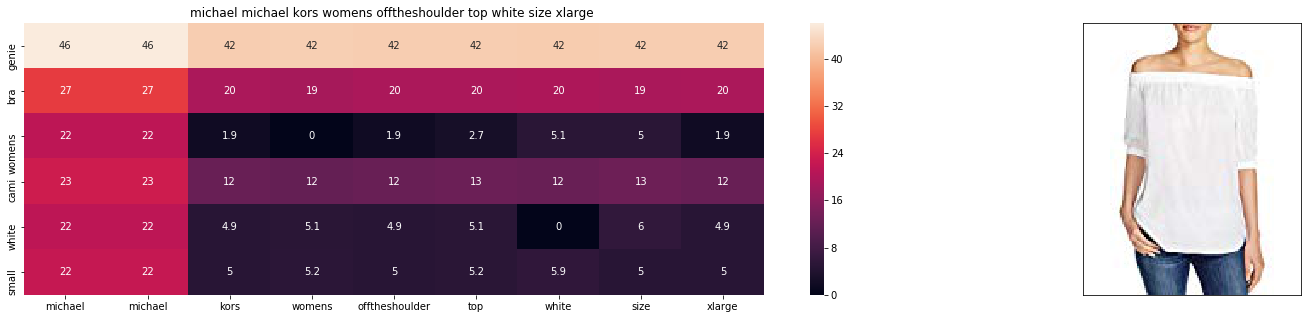

ASIN : B01BOU2FRU
Brand : MICHAEL Michael Kors
euclidean distance from input : 26.490509185436313


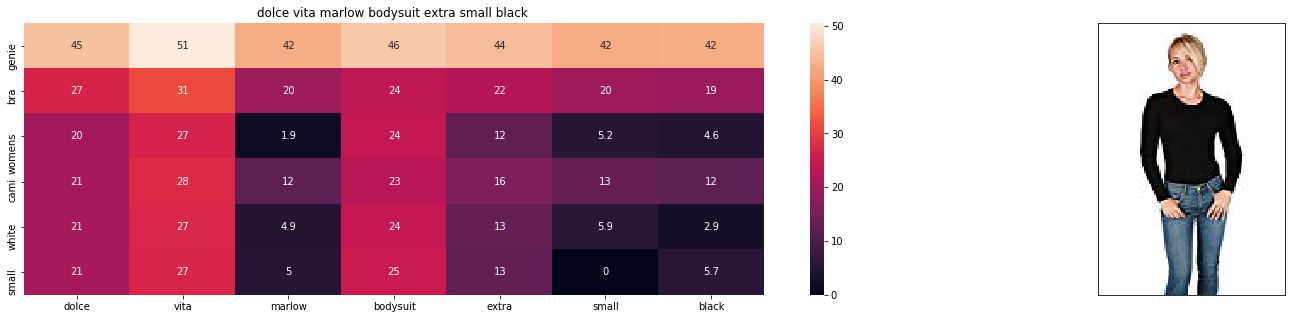

ASIN : B01N5K8RVX
Brand : Dolce Vita
euclidean distance from input : 26.728349877995235


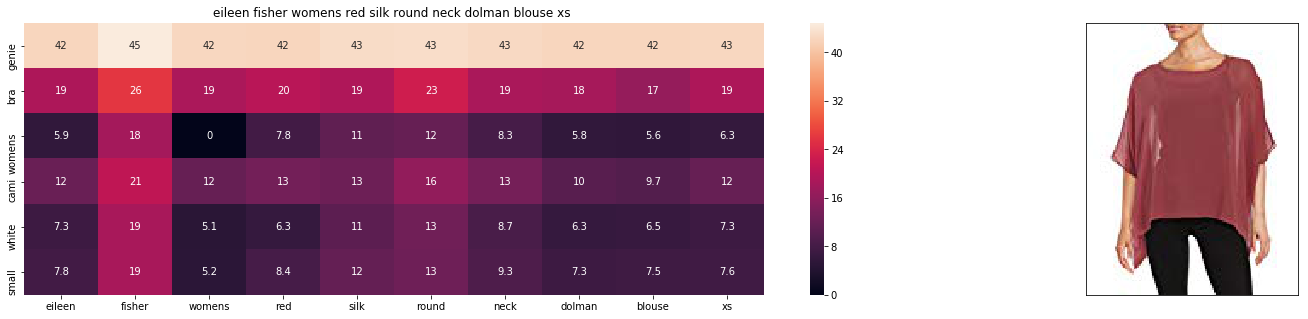

ASIN : B06Y3CKDML
Brand : Eileen Fisher
euclidean distance from input : 26.782724572819454


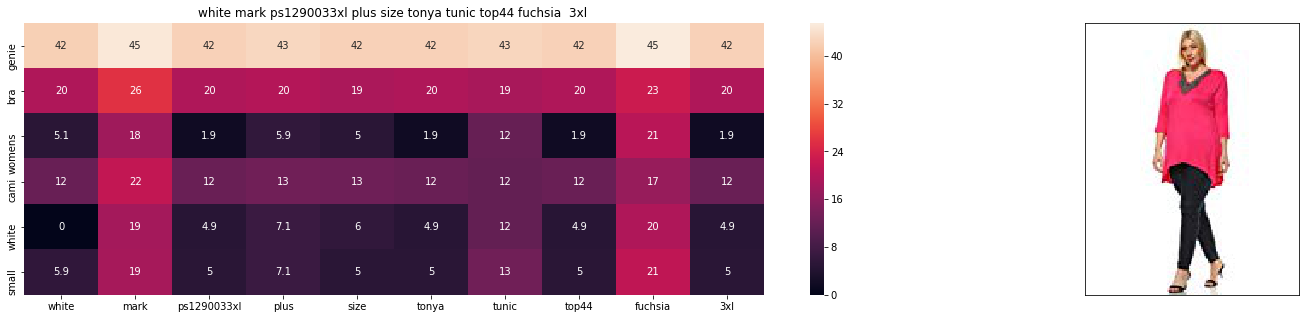

ASIN : B0747WZHK2
Brand : White Mark
euclidean distance from input : 26.78558777559568


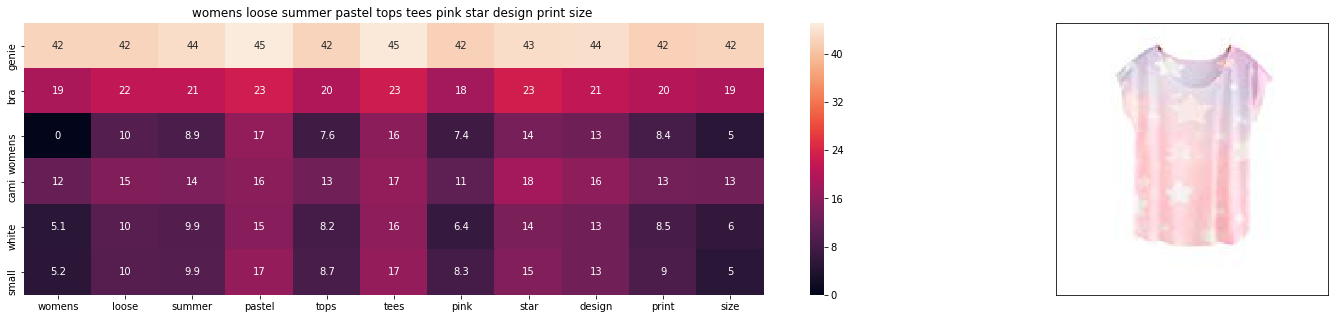

ASIN : B01L79BFYC
Brand : Namnoi Clothing Store
euclidean distance from input : 26.788338132231097


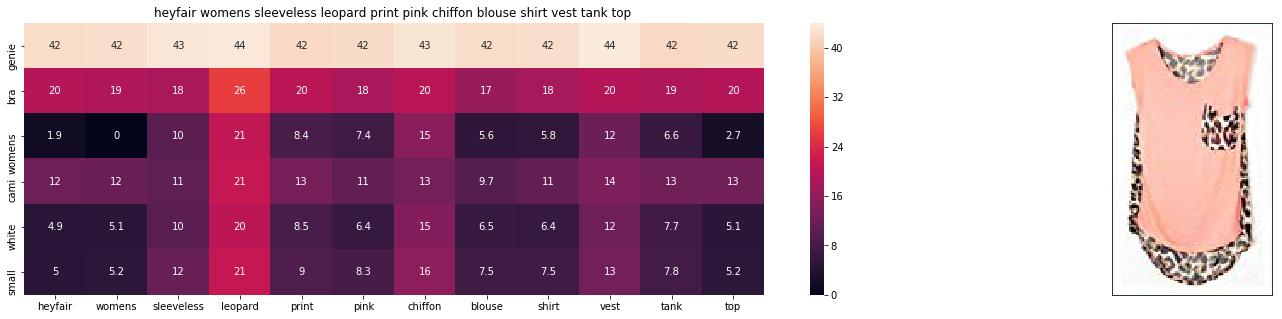

ASIN : B00W3MMKS8
Brand : HEYFAIR
euclidean distance from input : 26.826926367623464


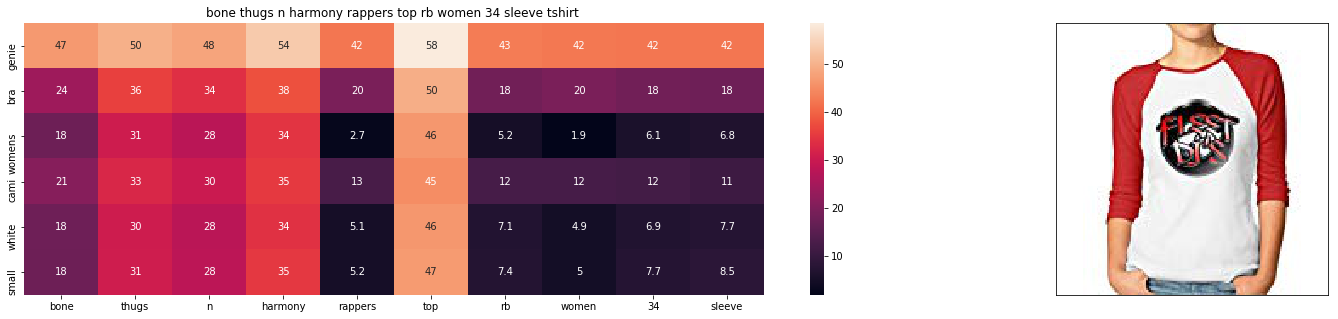

ASIN : B01G8N82KW
Brand : BRMWs
euclidean distance from input : 26.830492989321638


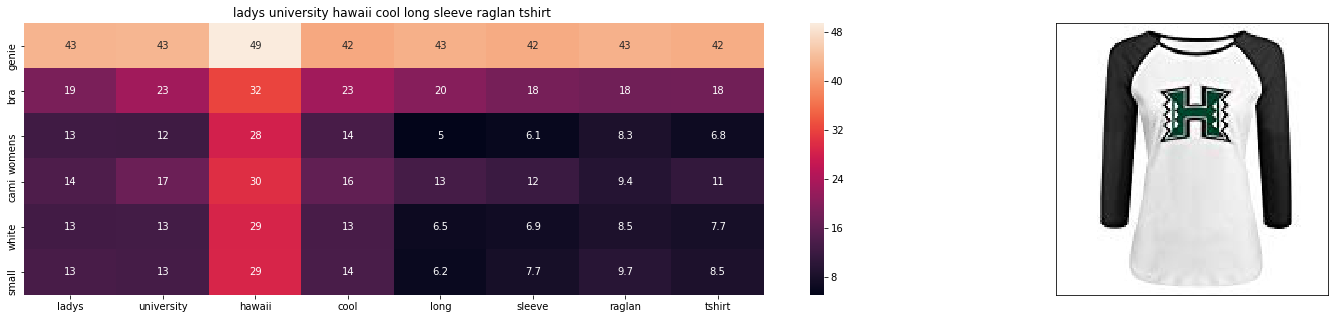

ASIN : B01M4FR83Y
Brand : ILITECK-P
euclidean distance from input : 26.83069338117327


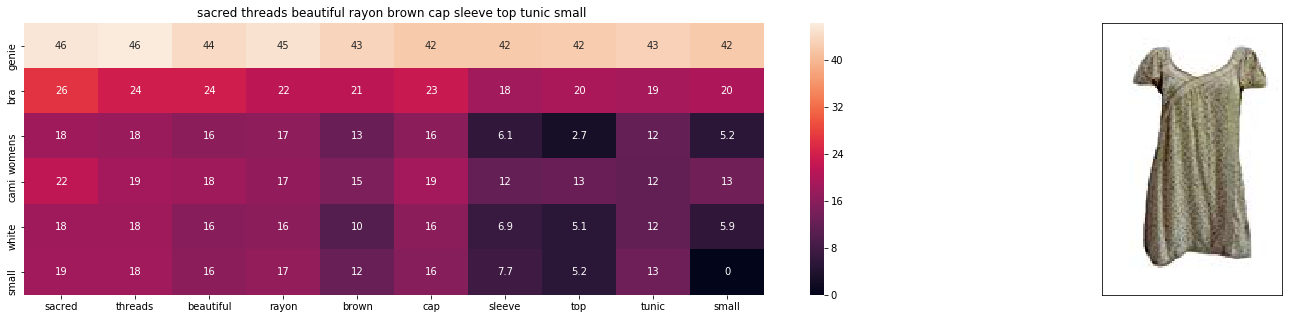

ASIN : B07522R7DH
Brand : Sacred Threads
euclidean distance from input : 26.868943895612443


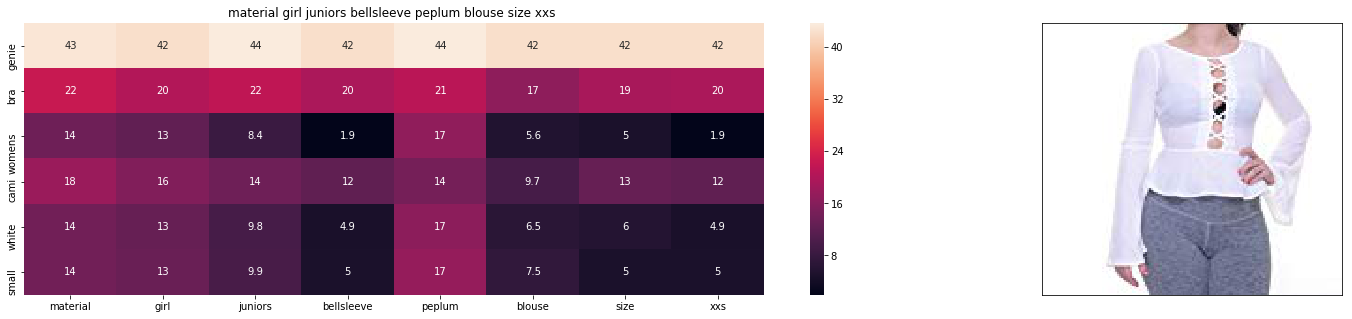

ASIN : B06XSH8WSS
Brand : Material Girl
euclidean distance from input : 26.921425017955844


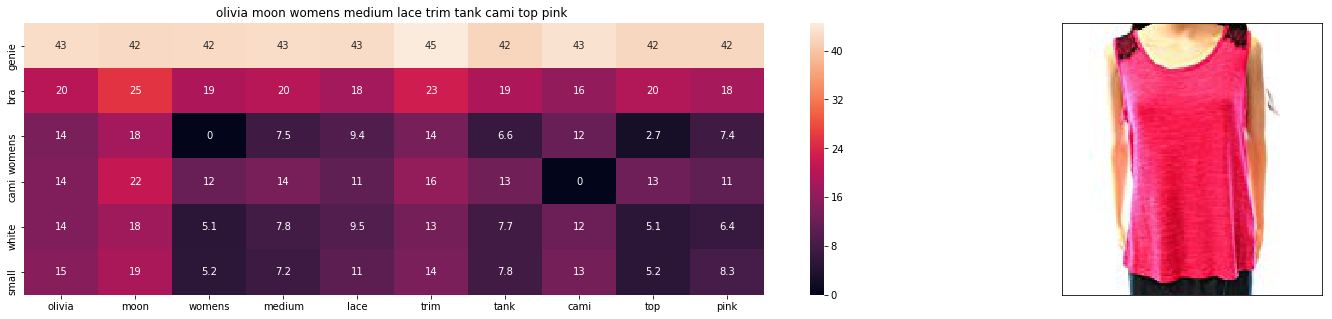

ASIN : B071W8XRB2
Brand : Olivia Moon
euclidean distance from input : 26.950566892852937


In [54]:
get_similar_products_cnn(1256,10,3,15, 20)